In [1]:
import cv2
import numpy as np
import time
from skimage.util import random_noise
import matplotlib.pyplot as plt
%matplotlib inline

## Seeded Region Growing

In [2]:
class SeededRegionGrowing:

    def __init__(self, seeds, img, k=1):
        """
        Inputs:
        seeds là tỉ lệ tọa độ các hạt giống đưa vào 
        img là ảnh gốc cần phân đoạn
        
        Atributes:
        mask là kết quả phân đoạn
        A là list chứa giá trị trung bình của các pixel có cùng nhãn
        SSL là Sequential Sorted List chứa các pixel được sắp xếp
        order là list chứa mức độ khác biệt của từng pixel tương ứng trong SSL
        """
        self.img = img
        self.mask = np.zeros(self.img.shape[:2], dtype=int)
        seeds = [[int(y * self.img.shape[0]), int(x * self.img.shape[1])] for x, y in seeds]
        self.A, seeds  = self.init_A(seeds, k)
        deltas = [np.min(self.get_variances(x)) for x in seeds]
        
        ssl = [seed + [delta] for seed, delta in zip(seeds, deltas)]
        ssl = sorted(ssl, key=lambda x: x[-1])
        self.SSL = [s[:-1] for s in ssl]
        self.order = [s[-1] for s in ssl]
        self.boundary = list()

    def get_variances(self, pixel):
        return [np.mean(
                    np.absolute(self.img[pixel[0], pixel[1]] - np.mean(a, axis= 0)),
                    axis=0) 
                for a in self.A]
    
    def coloring_mask(self, pixel):
        """
        Tô màu cho pixel và cập nhật lại cường độ màu trung bình của màu vừa tô
        """
        color = np.argmin(self.get_variances(pixel))
        self.mask[pixel[0], pixel[1]] = color + 1
        self.A[color] = np.vstack((self.A[color], self.img[pixel[0], pixel[1]]))

    def segment(self):
        start = time.time()
        while len(self.SSL) > 0:
            y = self.SSL.pop(0)
            self.order.pop(0)
            
            neighbors = self.get_neighbors(y[0], y[1])
            label = list()
            for neig in neighbors:
                self.add_neighbor(neig[1], neig[0])  
            label = [self.mask[x, y] for x, y in neighbors  if self.is_valid(y, x) and self.mask[x, y] > 0]
            if len(label) > 0:
                if label.count(label[0]) != len(label):
                    self.boundary.append(y)
                self.coloring_mask(y)
        print('Segmentation completely~')
        print('Execution time:', time.time()-start,'seconds')
    
    # lấy một vùng có bán kính k xung quanh seed để khởi tạo giá trị mean cho seed
    def init_A(self, seeds, k):
        A = np.empty((len(seeds),), dtype=object)
        new_seeds = list()
        for index, seed in enumerate(seeds):
            y = seed[0] - k
            x = seed[1] - k
            for i in range(k*2+1):
                for j in range(k*2+1):
                    if self.is_valid(x+j, y+i):
                        self.mask[y+i, x+j] = index + 1
                        new_seeds.append([y+i, x+j])
            A[index] = np.array([self.img[y, x] for y, x in new_seeds[index*((k*2+1)**2):]])
        return A, new_seeds

    # lấy 8 điểm lân cận pixel
    def get_neighbors(self, x, y):
        return [
            (x-1, y-1),
            (x-1, y),
            (x-1, y+1),
            (x, y+1),
            (x, y-1),
            (x+1, y-1),
            (x+1, y),
            (x+1, y+1),
        ]

    # kiểm tra xem tọa độ có nằm ngoài ảnh không
    def is_valid(self, x, y):
        return x>=0 and x<self.img.shape[1] and y>=0 and y<self.img.shape[0]

    # kiểm tra và thêm pixel vào SSL
    def add_neighbor(self, x, y):
        if self.is_valid(x, y) and (self.mask[y, x] == 0):
            delta = np.min(self.get_variances([y, x]))
            loc = 0
            for i in self.order:
                if i > delta:
                    break
                loc += 1
            self.SSL.insert(loc, [y, x])
            self.order.insert(loc, delta)
            self.mask[y, x] = -1

    def result(self):
        return self.mask


In [3]:
# srg = SeededRegionGrowing([(0.5, 0.5), (0.25, 0.8)], color_img, 3)
# srg = SeededRegionGrowing([(0.6, 0.5), (0.4, 0.4)], img_0)
def SRG(img, seeds, k= 2):
    srg = SeededRegionGrowing(seeds, img, k)
    start = time.time()
    srg.segment()
    execution_time = time.time() - start
    return srg.result(), execution_time

## Canny Edge Detection

In [4]:
def edge2mask(img):
    cnt = sorted(cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2], key=cv2.contourArea)[-1]
    mask = np.zeros((img.shape[0],img.shape[1]), np.uint8)
    mask = cv2.drawContours(mask, [cnt],-1, 255, -1)
    return mask

In [5]:
def CannyEdge(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    start = time.time()
    edge = cv2.Canny(gray_img, 150, 200)
    execution_time = time.time() - start
    return edge2mask(edge), edge, execution_time

## K-means Clustering

In [6]:
def Kmeans(img):
    flat_img = img.reshape((-1, 3))
    flat_img = np.float32(flat_img)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = 2
    start = time.time()
    ret,label,center=cv2.kmeans(flat_img,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
    execution_time = time.time()-start

    return label.reshape(img.shape[:2]), execution_time

## Grabcut Segmentation

In [7]:
def Grabcut(img, rect):
    gc_result = np.zeros(img.shape[:2], dtype=np.uint8)
    # rect = (40, 35, 425, 270)
    background = np.zeros((1, 65), dtype=np.float64)
    foreground = np.zeros((1, 65), dtype=np.float64)
    start = time.time()
    cv2.grabCut(img, gc_result, rect, background, foreground, 30, cv2.GC_INIT_WITH_RECT)
    execution_time = time.time()-start
    
    return gc_result, execution_time

# Functions to evaluate results

In [156]:
from sklearn.metrics import jaccard_score, f1_score

In [8]:
def Segmentation(img, seeds, k, rect):
    Masks = [0.]*4
    Times = [0.]*4
    Masks[0], Times[0] = SRG(img, seeds, k)
    Masks[1],_, Times[1] = CannyEdge(img)
    Masks[2], Times[2] = Kmeans(img)
    Masks[3], Times[3] = Grabcut(img, rect)
    return Masks, Times

In [162]:
def plots(mask, scores = None):
    labels = ['Seeded Region Growing', 'Canny Edge Detection', 'K-means Segmentation', 'Grabcut']
    fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(10, 8))
    if scores != None:
        ax[0, 0].set(xlabel = 'IoU Score: ' + str(round(scores[0][0], 3)) 
                    + '\nF1 Score: '+ str(round(scores[0][1], 3)))
        ax[0, 1].set(xlabel = 'IoU Score: ' + str(round(scores[1][0], 3))
                     + '\nF1 Score: '+ str(round(scores[1][1], 3)))
        ax[1, 0].set(xlabel = 'IoU Score: ' + str(round(scores[2][0], 3))
                     + '\nF1 Score: '+ str(round(scores[2][1], 3)))
        ax[1, 1].set(xlabel = 'IoU Score: ' + str(round(scores[3][0], 3))
                     + '\nF1 Score: '+ str(round(scores[3][1], 3)))
        
    ax[0, 0].imshow(mask[0])
    ax[0, 0].set_xticks([])
    ax[0, 0].set_yticks([])
    ax[0, 0].set_title(labels[0], fontsize=14)

    ax[0, 1].imshow(mask[1])
    ax[0, 1].set_xticks([])
    ax[0, 1].set_yticks([])
    ax[0, 1].set_title(labels[1], fontsize=14)

    ax[1, 0].imshow(mask[2])
    ax[1, 0].set_xticks([])
    ax[1, 0].set_yticks([])
    ax[1, 0].set_title(labels[2], fontsize=14)

    ax[1, 1].imshow(mask[3])
    ax[1, 1].set_xticks([])
    ax[1, 1].set_yticks([])
    ax[1, 1].set_title(labels[3], fontsize=14)
    fig.tight_layout()


In [174]:
def evaluate(ground_truth, pred):
    key = np.unique(pred)
    cases = [(0, 1), (1, 0)]
    score = [0., 0.]
    for x in cases:
        pred_ = pred.copy()
        pred_ = np.where(pred_ == 0, x[0], x[1])
        IoU = jaccard_score(ground_truth.flatten(), pred_.flatten())
        F1 = f1_score(ground_truth.flatten(), pred_.flatten())
        if IoU > score[0]:
            score = [IoU, F1]
            pred_true = pred_
    return (pred_true, score)

In [97]:
def get_evaluation(true, preds):
    masks = [i.copy() for i in preds]
    masks[0] = masks[0] - 1
    masks[1][masks[1] == 255] = 1
    masks[3][masks[3] < np.max(masks[3])] = 0
    masks[3][masks[3] == np.max(masks[3])] = 1
    
    results = [evaluate(true, pred) for pred in masks]
    return results

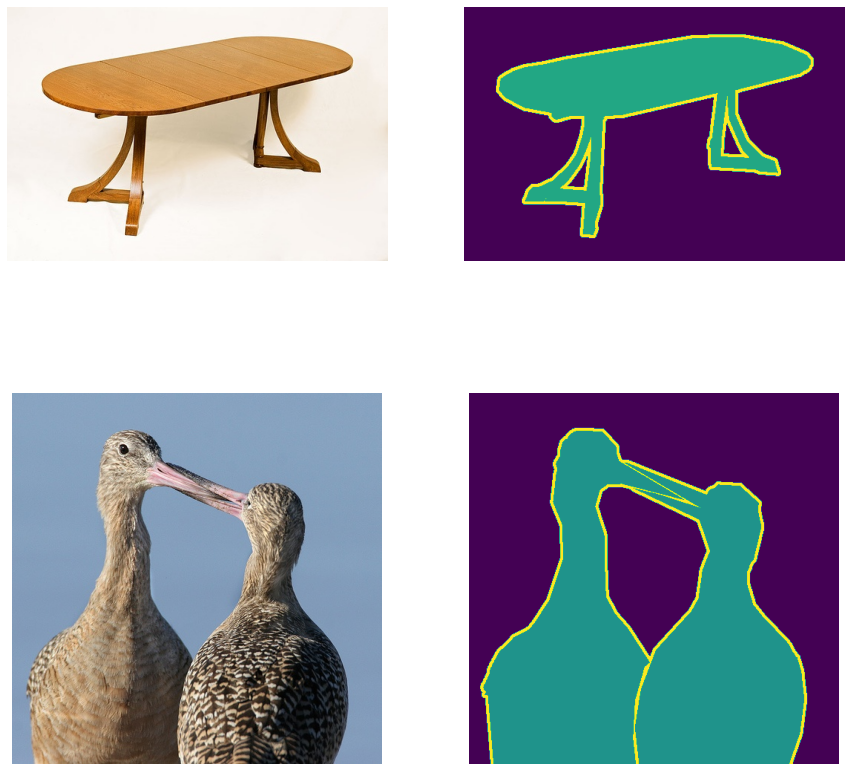

In [4]:
img_0 = cv2.imread('2007_001834.jpg', cv2.IMREAD_COLOR)
img_1 = cv2.imread('2007_005264.jpg', cv2.IMREAD_COLOR)
gt_0 = cv2.imread('2007_001834.png', cv2.IMREAD_GRAYSCALE)
gt_1 = cv2.imread('2007_005264.png', cv2.IMREAD_GRAYSCALE)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
axs[0, 0].imshow(cv2.cvtColor(img_0, cv2.COLOR_BGR2RGB))
axs[0, 0].axis('off')
axs[0, 1].imshow(gt_0)
axs[0, 1].axis('off')

axs[1, 0].imshow(cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB))
axs[1, 0].axis('off')
axs[1, 1].imshow(gt_1)
axs[1, 1].axis('off');

* Evaluate image 0

In [178]:
rect = (40, 35, 425, 270)
seeds = [(0.6, 0.5), (0.4, 0.4)]
k = 2
masks, times = Segmentation(img_0, seeds, k, rect)

Segmentation completely~
Execution time: 491.52656745910645 seconds


In [179]:
true = gt_0.copy()
true[true > 0] = 1
evaluations = get_evaluation(true, masks)
preds = [ev[0] for ev in evaluations]
scores = [ev[1] for ev in evaluations]

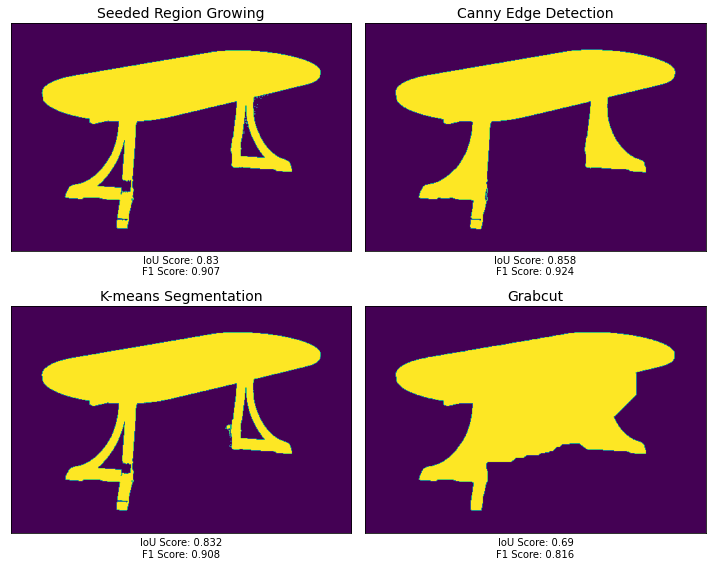

In [180]:
plots(preds, scores)

* Evaluate Image 1

In [146]:
rect = (16, 45, 445, 500)
seeds = [(0.5, 0.5), (0.25, 0.8)]
k = 3
masks, times = Segmentation(img_1, seeds, k, rect)

Segmentation completely~
Execution time: 1191.8779759407043 seconds


In [165]:
true = gt_1.copy()
true[true > 0] = 1
evaluations = get_evaluation(true, masks)
preds = [ev[0] for ev in evaluations]
scores = [ev[1] for ev in evaluations]

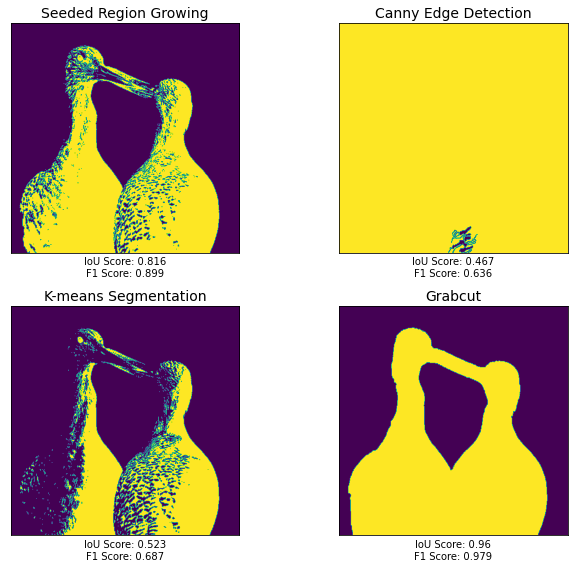

In [166]:
plots(preds, scores)

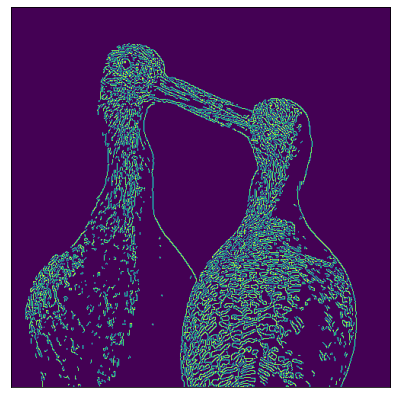

In [153]:
plt.figure(figsize=(7, 7))
_, edge, _ = CannyEdge(img_1)
plt.imshow(edge)
plt.xticks([])
plt.yticks([]);